In [1]:
from __future__ import (absolute_import, division, print_function)

In [2]:
%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow.feature_column import numeric_column as num
from tensorflow.feature_column import bucketized_column as buck
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
sns.set()

In [4]:
tf.__version__

'1.13.1'

In [5]:
sess = tf.InteractiveSession()

# Classifying Fat Tails
Here we try to explore the possibility to predict a fat-tailed distribution the shape of which depends on two variables. We hope that this helps us to come up with some reasonable prediction scheme for the flight delays.

## Logarithmic bucketizing

Test data

In [6]:
inp = tf.constant([-4, 2, 10, 100, 30, 2, 3, 50, 300], dtype=tf.float64)
sess.run(inp)

array([ -4.,   2.,  10., 100.,  30.,   2.,   3.,  50., 300.])

Observe that the different values of the test dataset properly distribute into buckets defined by exponentially growing boundaries.

In [9]:
boundaries = [7.5, 15, 30, 60, 120]
column = buck(num("values"), boundaries)
bucketized = tf.feature_column.input_layer( 
            {'values': inp}, feature_columns=[column])
sess.run(bucketized)

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

## Simulating fat-tailed data

The distribution of departure delays is definitely not Gaussian. It rather looks like the [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution). 
The probability density function of the Gamma distribution with scale $\theta$ and shape $\beta$ 
is defined by

$$ {\frac {1}{\Gamma (k)\theta ^{k}}}x^{k-1} \cdot e^{-{\frac {x}{\theta }}}$$

That's just for your information. We don't need the details here. But please observe the shape of the distribution for different values of $k$ and $\theta$ as functions of our input variables $x$ and $y$.

In [10]:
def sample_for(x, y, n=1):    
    assert x>=0 and x<1
    assert y>=0 and y<1
    res = np.random.gamma(1+x,20*y+1, n) 
    return res if n>1 else res[0]
sample_for(0,.1)

0.8281364209559745

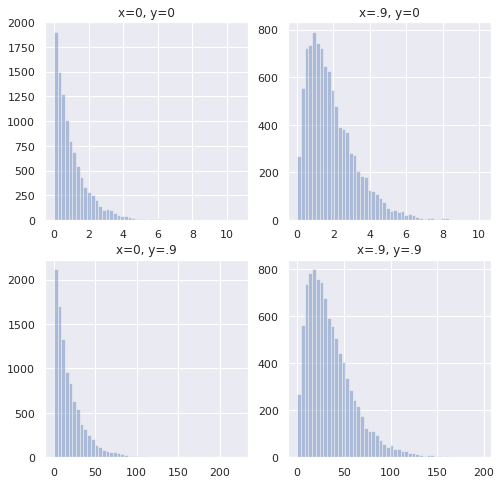

In [11]:
n = 10000
f, axes = plt.subplots(2, 2, figsize=(8,8), sharex=False)

# Plot a simple histogram with binsize determined automatically
sns.distplot(sample_for(0,0,n=n), kde=False, ax=axes[0, 0])
axes[0,0].set_title("x=0, y=0")

# Plot a kernel density estimate and rug plot
sns.distplot(sample_for(.9,0, n=n), kde=False, ax=axes[0, 1])
axes[0,1].set_title("x=.9, y=0")

# Plot a filled kernel density estimate
sns.distplot(sample_for(0,.9, n=n), kde=False, ax=axes[1, 0])
axes[1, 0].set_title("x=0, y=.9")

# Plot a historgram and kernel density estimate
sns.distplot(sample_for(.9,.9, n=n), kde=False, ax=axes[1, 1])
axes[1,1].set_title("x=.9, y=.9");

While $x$ appears to be shifting the *center* to the right as it grows, $y$ is apparently responsible for the length of the tail.

In the following, we will draw triples $(x, y, f(x,y))$ from uniformly distributed $x$ and $y$. $f(x,y)$ is drawn from the respective distribution for $x$ and $y$.

In [12]:
def create_input_data(n):
    x=np.random.uniform(size=n)
    y=np.random.uniform(size=n)
    return [[sx, sy, sample_for(sx,sy)] for sx,sy in zip(x,y)]

create_input_data(4)

[[0.7927728370902035, 0.3893753503257238, 14.076824432822821],
 [0.18470214226647597, 0.3472506796196244, 28.209998273250413],
 [0.020187634966840395, 0.33522126927767826, 8.568034298524992],
 [0.6854365651458646, 0.4129626464537832, 6.524161103694919]]

---

## Training
Now we want to train a model to reproduce the distribution of flight delays $f$.
The input into the model is called ```X```, which contains ```x,y```.

In [13]:
labeled_data = create_input_data(10000)
X=tf.constant(np.transpose(labeled_data)[0:2].T)
sess.run(X)[:4]

array([[0.91823579, 0.56535605],
       [0.62519185, 0.24309094],
       [0.47230016, 0.29850713],
       [0.12995077, 0.47881512]])

In [14]:
corners = [[0.1, 0.1],[0.1, 0.9],[0.9, 0.1],[0.9, 0.9]]
Xt=tf.constant(corners, dtype=tf.float64)

The labels are those values that come from the respective fat-tailed distributions.

In [24]:
L=np.transpose(labeled_data)[2].T
L[:4]

array([32.31219081,  1.28244266, 22.1227245 ,  5.05040106])

We want those values bucketized:

In [16]:
boundaries = [7.5, 15, 30, 60, 120]
column = buck(num("values"), boundaries)
L_bucketized = tf.feature_column.input_layer( 
            {'values': L}, feature_columns=[column])
L_bucketized = tf.cast(L_bucketized, dtype=tf.float64)
sess.run(L_bucketized)[:4]

array([[0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

Now we need a function that takes ```X``` as input und returns a 6-dimensional vector that, after sufficient training, will hopefully reflect the probabilities for $f(x,y)$ to appear in the respective bucket.

In [17]:
Theta = tf.Variable(np.random.normal(0, .2, size=[2,6]))
b = tf.Variable(np.random.normal(0, .2, size=[6]))

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
z=tf.matmul(X, Theta) + b
zt=tf.matmul(Xt, Theta) + b
pred=tf.nn.softmax(zt)
loss = tf.losses.softmax_cross_entropy(L_bucketized, z)

lr = .1

trainer = tf.train.AdamOptimizer(learning_rate=lr)
step=trainer.minimize(loss=loss)
init = tf.global_variables_initializer()


### Verifying Convergence
By looking at the first consecutive values for the loss, we verify that it monotonously increases.

In [19]:
sess.run(init)
for n in range(10):
    l, _ = sess.run([loss, step])
    print(l)

1.8012683391571045
1.6896058320999146
1.6111631393432617
1.5584392547607422
1.5234657526016235
1.4987303018569946
1.4791640043258667
1.4626613855361938
1.448588490486145
1.4363751411437988


### Full Training

In [20]:
for n in range(1000):
    l, _ = sess.run([loss, step])

In [21]:
sess.run(loss)

1.214325189590454

---
### Verifiying the result
We demonstrate the plausibility of the result by comparing the distribution for the extreme pairs of parameters $x_d$ and $y_d$ with the *learned* distribution.

In [22]:
buckets = np.append([0], boundaries)

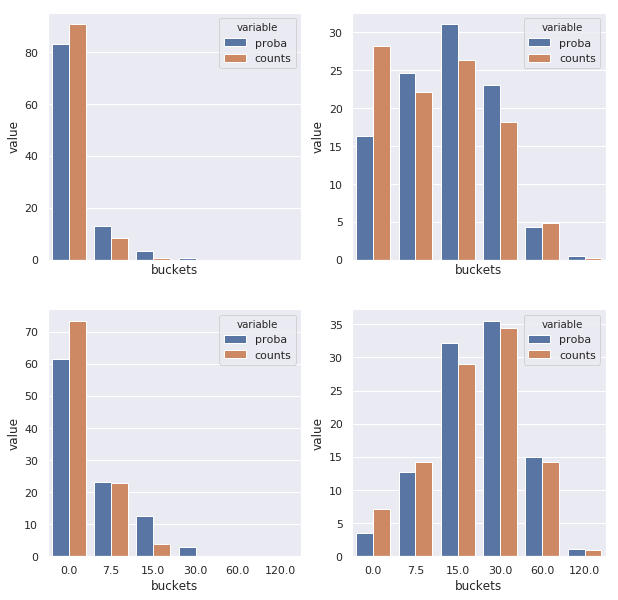

In [25]:
xt, pt = sess.run([Xt, pred])
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True)
for ind in range(4):
    x_d, y_d = xt[ind][0], xt[ind][1]

    xd, yd = xt[ind][0], xt[ind][1]
    df=pd.DataFrame.from_dict(
        {'buckets': buckets, 'proba': np.round(pt[ind]*100, 2)})

    n_samples = 10000
    sample=sample_for(x_d, y_d, n=n_samples)
    right_boundary = np.max([np.max(sample)+1, 121])
    bins=np.append(buckets, right_boundary)
    counts,_ = np.histogram(sample, bins=bins)
    df['counts']= counts/n_samples * 100
    df = pd.melt(df, id_vars=['buckets'], value_vars=['proba', 'counts'])
    i=ind // 2
    j=ind % 2
    sns.barplot(x='buckets', y='value', hue='variable', ax=axes[i][j], data=df)

Not too bad, is it? Rather than making a prediction that won't be so helpful because of the massive tail in the distribution, we can let the decision making up to the user. 

---

## Predicting by distribution

We will provide the users with a color scheme indicating the probability distribution

In [26]:
colors = ['#FF0000', '#FF7000', '#FFC000', '#F0F000', '#80FF00', '#00FF00']

In [27]:
accus=[[]]
for i in range(4):
    accus.append([])
    s = 0
    for p in pt[i]:
        s += p
        accus[i].append(s)

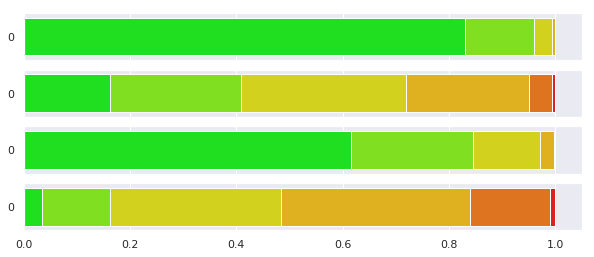

In [28]:
f, axes = plt.subplots(4, 1, figsize=(10, 4), sharex=True)
for i in range(4):
    disp = zip(reversed(accus[i]), colors)
    for d in disp:
        sns.barplot(x=[d[0]], y=[0], orient='h', color=d[1], ax=axes[i])